In [1]:
from functions import transform_raw_data, clean_df, impute_fit_df, impute_transform_df

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.metrics import  f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split,  StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from hyperopt import fmin, tpe, hp, STATUS_OK

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

- target = fatality
- only considered columns with roughly <30% missing
- removing missing values

In [2]:
# creating dictionary of categorical column names : corresponding one-hot encoded columns names
# this is used to make sure every X dataset in the CV has the same columns
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
cols = ['day_of_week','time','first_road_class','road_type','speed_limit','junction_detail','second_road_class',
        'light_conditions','weather_conditions','road_surface_conditions','vehicle_type','age_of_casualty','casualty_severity',
        'pedestrian_crossing_physical_facilities','vehicle_subtype','vehicle_manoeuvre','season','junction_control',
        'propulsion_code','urban_or_rural_area','first_point_of_impact']
df = df[cols]
categorical_columns = [col for col in df.select_dtypes(include='object').columns if col not in ['time','casualty_severity']] + ['speed_limit']
df = clean_df(df)
categorical_freqs, vars_to_groupby, continuous_medians_grouped, continuous_medians, scaler = impute_fit_df(df)
df = impute_transform_df(df, categorical_freqs, vars_to_groupby, continuous_medians_grouped, continuous_medians, scaler, df.columns)

encoded_cols_dict = {}

for col in categorical_columns:
    encoded_cols = [encoded_col for encoded_col in df.columns if col in encoded_col]
    if len(encoded_cols) > 0:
        encoded_cols_dict[col] = encoded_cols

c:\Users\danjr\Documents\Projects\cycle collisions\functions.py:6: DtypeWarning: Columns (0,2,39,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv, header=0)


In [3]:
# custom Transformer class for applying preprocessing in pipeline
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_encoded_cols=None):
        self.categorical_freqs = None
        self.continuous_medians_grouped = None
        self.continuous_medians = None
        self.vars_to_groupby = None
        self.scaler = None
        self.features = None
        self.one_hot_encoded_cols = one_hot_encoded_cols

    # fit is only called on the train data
    def fit(self, X, y=None):
        # calculate impute values
        self.categorical_freqs, self.vars_to_groupby, self.continuous_medians_grouped, self.continuous_medians, self.scaler = impute_fit_df(X)
        return self

    # transform is called on the both the train and test data
    def transform(self, X, y=None):
        # apply the preprocessing function to the data
        df = impute_transform_df(X, self.categorical_freqs, self.vars_to_groupby, self.continuous_medians_grouped,
                                 self.continuous_medians, self.scaler, X.columns,
                                 encoded_cols_dict=encoded_cols_dict, one_hot_encoded_cols=self.one_hot_encoded_cols)
        df['log_engine_capacity_cc'] = np.log(df['engine_capacity_cc'] + 0.0000001)
        self.features = df.columns
        return df

In [4]:
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
cols = ['age_of_casualty','engine_capacity_cc','age_of_driver',
            'vehicle_type','vehicle_subtype','junction_detail','towing_and_articulation','vehicle_manoeuvre',
            'casualty_imd_decile','pedestrian_crossing_physical_facilities','pedestrian_crossing_human_control','driver_imd_decile',
            'day_of_week','time_period','season',
            'first_road_class','road_type','speed_limit','junction_control','second_road_class',
            'light_conditions','weather_conditions','road_surface_conditions','propulsion_code','sex_of_casualty',
            'urban_or_rural_area','casualty_home_area_type','first_point_of_impact','junction_location','casualty_severity','time'
        ]
df = clean_df(df)
df['fatality'] = np.where(df['casualty_severity'] == "Fatal", 1, 0)
target = 'fatality'
df = df[cols + [target]]

c:\Users\danjr\Documents\Projects\cycle collisions\functions.py:6: DtypeWarning: Columns (0,2,39,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv, header=0)


In [5]:
df.shape

(16155, 32)

feature engineering

In [6]:
df['hour'] = df.time.str.slice(start=0, stop=2).astype('int')
df['morning'] = np.where((df['hour'] >= 0) & (df['hour'] <= 12), 1, 0)
df['evening'] = np.where((df['hour'] >= 16) & (df['hour'] <= 22), 1, 0)

df['casualty_imd_decile_lessdeprived'] = np.where(df['casualty_imd_decile'].str.contains('Le'), 1, 0)
df['casualty_imd_decile_moredeprived'] = np.where(df['casualty_imd_decile'].str.contains('Mo'), 1, 0)
df['driver_imd_decile_lessdeprived'] = np.where(df['driver_imd_decile'].str.contains('Le'), 1, 0)
df['driver_imd_decile_moredeprived'] = np.where(df['driver_imd_decile'].str.contains('Mo'), 1, 0)

df['turning_left_or_right'] = np.where(df['vehicle_manoeuvre'].str.contains('Turning'), 1, 0)

df['poor_lighting'] = np.where(df['light_conditions'].str.contains('lights un|no lighting'), 1, 0)

df['raining_no_high_wind'] = np.where(df['weather_conditions'] == 'Raining no high wind', 1, 0)
df['high_wind_or_fog'] = np.where(df['weather_conditions'].str.contains('+ high winds|Fog|Other'), 1, 0)

experiments

In [7]:
features = ['age_of_casualty','engine_capacity_cc','vehicle_type','vehicle_subtype',
            'junction_detail','vehicle_manoeuvre',
            'casualty_imd_decile_lessdeprived','casualty_imd_decile_moredeprived',
            'driver_imd_decile_lessdeprived','driver_imd_decile_moredeprived',
            'morning','evening','turning_left_or_right','poor_lighting',
            'season','first_road_class','second_road_class','road_type',
            'speed_limit','junction_control','road_surface_conditions','propulsion_code',
            'urban_or_rural_area','first_point_of_impact']
one_hot_encoded_cols = [
    'vehicle_type_Car',
    'vehicle_type_Pedal cycle',
    'vehicle_subtype_1. HGV',
    'vehicle_subtype_3. Bus',
    'junction_detail_Not at junction or within 20 metres',
    'junction_detail_Roundabout',
    'vehicle_manoeuvre_Going ahead other',
    'season_winter',
    'first_road_class_A',
    'first_road_class_Unclassified',
    'road_type_Dual carriageway',
    'junction_control_Give way or uncontrolled',
    'second_road_class_Unclassified',
    'road_surface_conditions_Wet or damp',
    'propulsion_code_Heavy oil',
    'propulsion_code_Petrol',
    'propulsion_code_Undefined',
    'urban_or_rural_area_Rural',
    'first_point_of_impact_Front'
]

0.007692307692307692


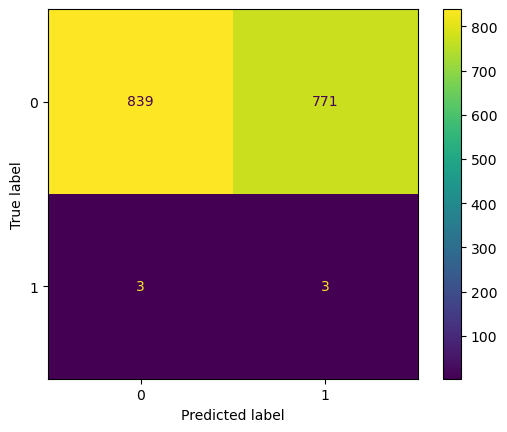

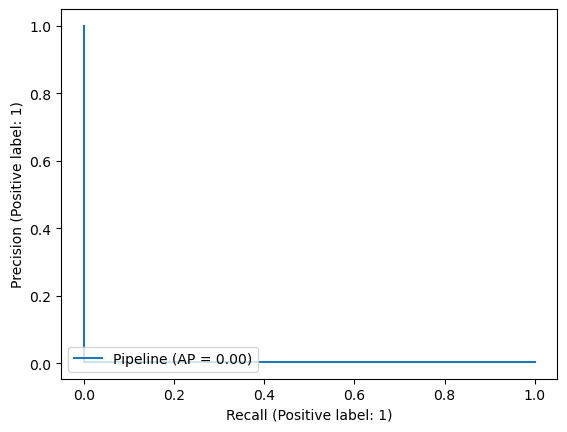

In [8]:
# baseline accuracy -> dummy classifier predicting class at random
pipeline = Pipeline([
    ('custom_preprocessor', CustomPreprocessor()),
    ('classifier', DummyClassifier(strategy="uniform"))
])
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.1, random_state=42)
pipeline.fit(X_train, y_train)
y_pred_dummy = pipeline.predict(X_test)
precision = f1_score(y_test, y_pred_dummy)
print(precision)
cm = confusion_matrix(y_test, y_pred_dummy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()

PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.1, random_state=42)

In [10]:
counter = Counter(y_train)
print(counter)

Counter({0: 14454, 1: 85})


Random forests

a. class weight balanced

In [11]:
def run_experiment(features, param_distributions, pipeline,
                   n_splits=4, n_iter=40, 
                   classifier=None, one_hot_encoded_cols=None, plot_param_charts=True):

    cv = StratifiedKFold(n_splits=n_splits)
    scoring = {
        "precision": make_scorer(precision_score)
    }
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,  # Number of random combinations to try
        scoring=scoring,  # Choose your preferred metric
        cv=cv,  # StratifiedKFold cross-validation
        verbose=10,  # Print out progress
        n_jobs=1,  # Use all available cores
        random_state=42,  # Reproducibility
        refit="precision",
        return_train_score=True
    )
    random_search.fit(X_train, y_train)
    print(random_search.best_score_, random_search.best_params_)

    clf = random_search.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    print(precision_score(y_test, y_pred))
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
    plt.show()

    # for each parameter, plot line graphs of the train auc score, test auc score, and train - test score (to identify overfitting)
    if plot_param_charts:
        cv_results_df = pd.DataFrame(random_search.cv_results_)
        params = list(cv_results_df.params[0].keys())
        cv_results_df['train_test_diff_precision'] = cv_results_df['mean_train_precision'] - cv_results_df['mean_test_precision']

        num_cols = 3
        num_rows = (3*len(param_distributions) + num_cols - 1) // num_cols
        fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(15, 4*num_rows))
        ax = ax.flatten()

        for i, param in enumerate(params):
            sns.lineplot(cv_results_df, x='param_' + param, y='mean_test_precision', label='Test precision', ax=ax[i*3+0])
            sns.lineplot(cv_results_df, x='param_' + param, y='mean_train_precision', label='Train precision', ax=ax[i*3+1])
            sns.lineplot(cv_results_df, x='param_' + param, y='train_test_diff_precision', label='Train-Test precision Difference', ax=ax[i*3+2])

        plt.legend()
        plt.show()
    
    return random_search

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV 1/4; 1/40] START classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367
[CV 1/4; 1/40] END classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367; precision: (train=0.062, test=0.037) total time=   8.0s
[CV 2/4; 1/40] START classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367
[CV 2/4; 1/40] END classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367; precision: (train=0.062, test=0.032) total time=   8.1s
[CV 3/4; 1/40] START classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367
[CV 3/4; 1/40] END classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367; precision: (train=0.063, test=0.050) total time=   9.7s
[CV 4/4; 1/40] START classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/4; 24/40] END classifier__max_depth=598, classifier__max_features=17, classifier__min_samples_split=2; precision: (train=1.000, test=0.000) total time=  10.0s
[CV 2/4; 24/40] START classifier__max_depth=598, classifier__max_features=17, classifier__min_samples_split=2
[CV 2/4; 24/40] END classifier__max_depth=598, classifier__max_features=17, classifier__min_samples_split=2; precision: (train=1.000, test=0.000) total time=  10.1s
[CV 3/4; 24/40] START classifier__max_depth=598, classifier__max_features=17, classifier__min_samples_split=2


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/4; 24/40] END classifier__max_depth=598, classifier__max_features=17, classifier__min_samples_split=2; precision: (train=1.000, test=0.000) total time=  10.2s
[CV 4/4; 24/40] START classifier__max_depth=598, classifier__max_features=17, classifier__min_samples_split=2


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 24/40] END classifier__max_depth=598, classifier__max_features=17, classifier__min_samples_split=2; precision: (train=1.000, test=0.000) total time=   9.9s
[CV 1/4; 25/40] START classifier__max_depth=659, classifier__max_features=30, classifier__min_samples_split=205
[CV 1/4; 25/40] END classifier__max_depth=659, classifier__max_features=30, classifier__min_samples_split=205; precision: (train=0.097, test=0.047) total time=  12.5s
[CV 2/4; 25/40] START classifier__max_depth=659, classifier__max_features=30, classifier__min_samples_split=205
[CV 2/4; 25/40] END classifier__max_depth=659, classifier__max_features=30, classifier__min_samples_split=205; precision: (train=0.090, test=0.042) total time=  12.9s
[CV 3/4; 25/40] START classifier__max_depth=659, classifier__max_features=30, classifier__min_samples_split=205
[CV 3/4; 25/40] END classifier__max_depth=659, classifier__max_features=30, classifier__min_samples_split=205; precision: (train=0.096, test=0.060) total time=  12.9

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/4; 30/40] END classifier__max_depth=327, classifier__max_features=2, classifier__min_samples_split=10; precision: (train=0.951, test=0.000) total time=   6.1s
[CV 2/4; 30/40] START classifier__max_depth=327, classifier__max_features=2, classifier__min_samples_split=10
[CV 2/4; 30/40] END classifier__max_depth=327, classifier__max_features=2, classifier__min_samples_split=10; precision: (train=0.925, test=0.000) total time=   5.9s
[CV 3/4; 30/40] START classifier__max_depth=327, classifier__max_features=2, classifier__min_samples_split=10
[CV 3/4; 30/40] END classifier__max_depth=327, classifier__max_features=2, classifier__min_samples_split=10; precision: (train=0.983, test=0.000) total time=   6.2s
[CV 4/4; 30/40] START classifier__max_depth=327, classifier__max_features=2, classifier__min_samples_split=10
[CV 4/4; 30/40] END classifier__max_depth=327, classifier__max_features=2, classifier__min_samples_split=10; precision: (train=0.937, test=0.000) total time=   6.3s
[CV 1/4; 3

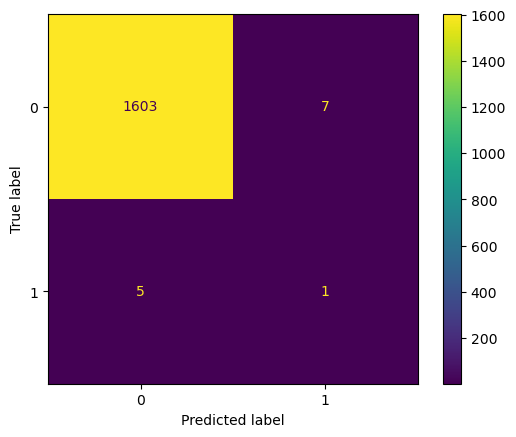

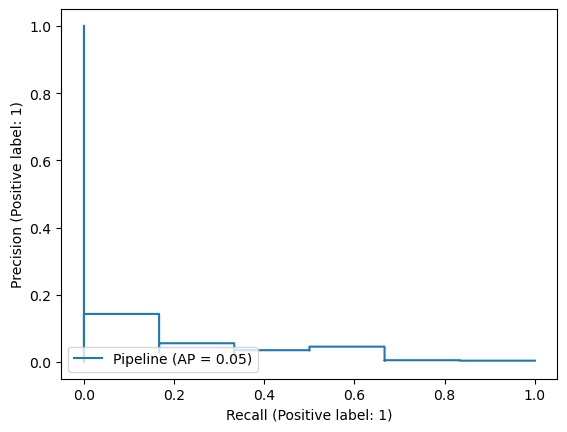

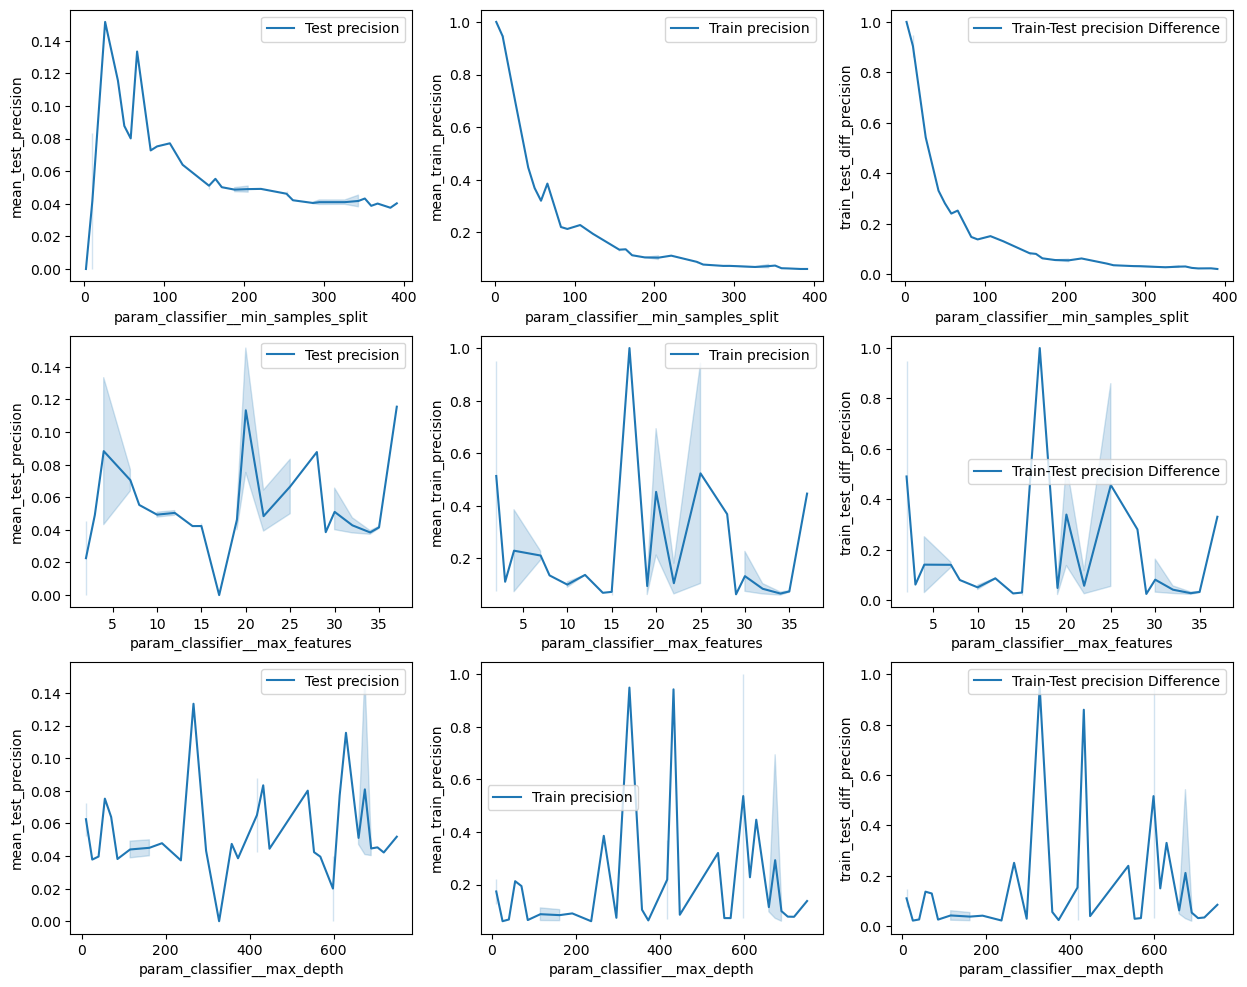

In [12]:
param_distributions = {
        "classifier__min_samples_split": [int(i) for i in np.linspace(2, 400, 50)],
        "classifier__max_features": [int(i) for i in np.linspace(1, 37, 30)],
        "classifier__max_depth": [int(i) for i in np.linspace(10, 750, 50)] + [None]
    }
classifier = RandomForestClassifier(n_estimators=750, class_weight='balanced')
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('classifier', classifier)
    ])
random_search = run_experiment(features, param_distributions, pipeline, 
                               n_iter=40, n_splits=4, 
                               classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

b. smote

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV 1/4; 1/40] START classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367
[CV 1/4; 1/40] END classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367; precision: (train=0.122, test=0.056) total time= 1.0min
[CV 2/4; 1/40] START classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367
[CV 2/4; 1/40] END classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367; precision: (train=0.089, test=0.034) total time=  59.6s
[CV 3/4; 1/40] START classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367
[CV 3/4; 1/40] END classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=367; precision: (train=0.101, test=0.044) total time= 1.0min
[CV 4/4; 1/40] START classifier__max_depth=161, classifier__max_features=19, classifier__min_samples_split=

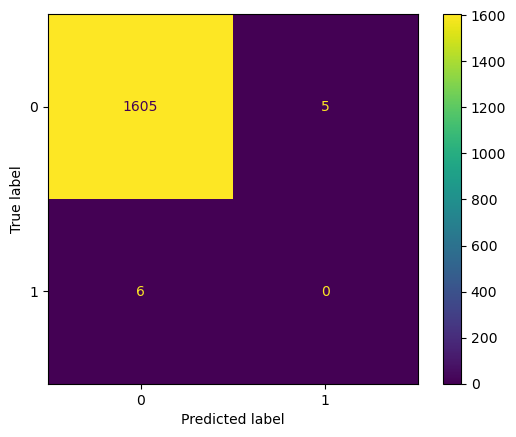

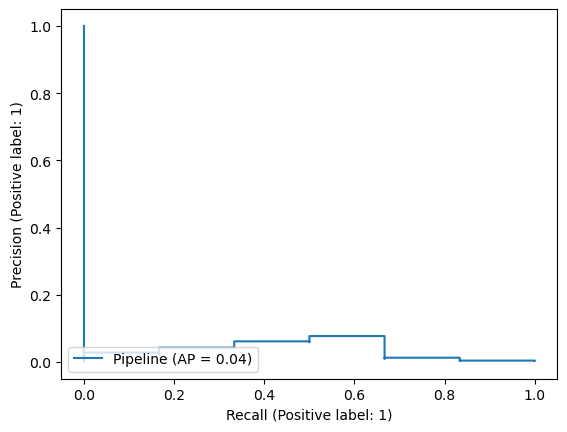

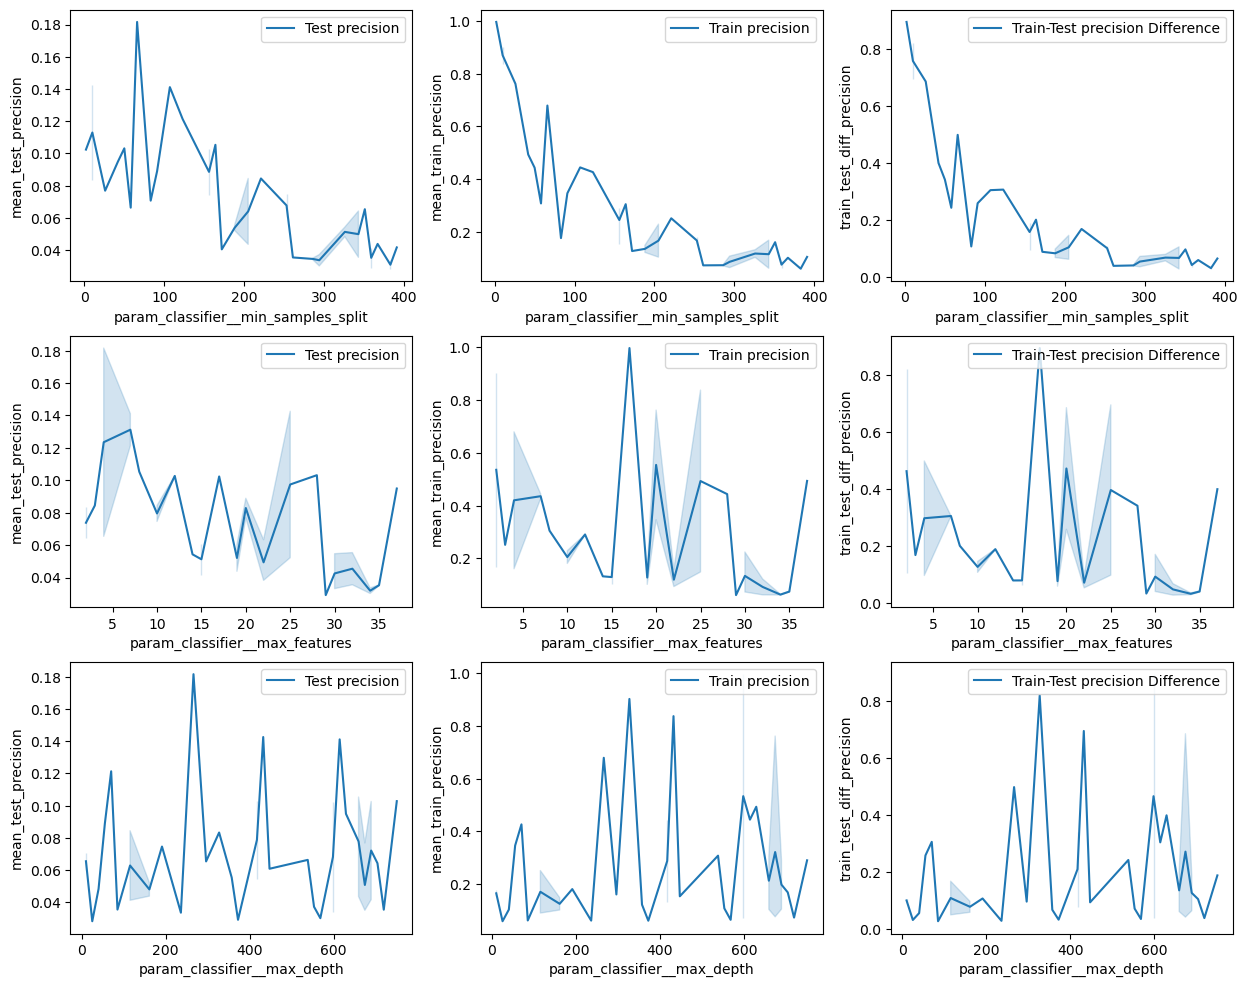

In [13]:
param_distributions = {
        "classifier__min_samples_split": [int(i) for i in np.linspace(2, 400, 50)],
        "classifier__max_features": [int(i) for i in np.linspace(1, 37, 30)],
        "classifier__max_depth": [int(i) for i in np.linspace(10, 750, 50)] + [None]
    }
classifier = RandomForestClassifier(n_estimators=750)
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('over', SMOTE(sampling_strategy='not majority')),
        ('classifier', classifier)
    ])
random_search = run_experiment(features, param_distributions, pipeline, 
                               n_iter=40, n_splits=4, 
                               classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

XGBoost

a. balanced sampling

In [14]:
counter = Counter(df[target])
scale_pos_weight = counter[0] / counter[1]
scale_pos_weight

176.52747252747253

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV 1/4; 1/100] START classifier__alpha=13.68421052631579, classifier__colsample_bytree=0.6666666666666666, classifier__gamma=14.736842105263158, classifier__lambda=9.473684210526315, classifier__max_depth=429, classifier__min_child_weight=11.578947368421051, classifier__subsample=0.9444444444444444
[CV 1/4; 1/100] END classifier__alpha=13.68421052631579, classifier__colsample_bytree=0.6666666666666666, classifier__gamma=14.736842105263158, classifier__lambda=9.473684210526315, classifier__max_depth=429, classifier__min_child_weight=11.578947368421051, classifier__subsample=0.9444444444444444; precision: (train=0.137, test=0.043) total time=   0.3s
[CV 2/4; 1/100] START classifier__alpha=13.68421052631579, classifier__colsample_bytree=0.6666666666666666, classifier__gamma=14.736842105263158, classifier__lambda=9.473684210526315, classifier__max_depth=429, classifier__min_child_weight=11.578947368421051, classifier__subsampl

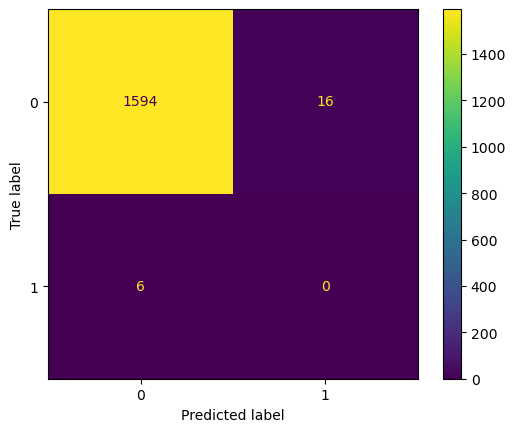

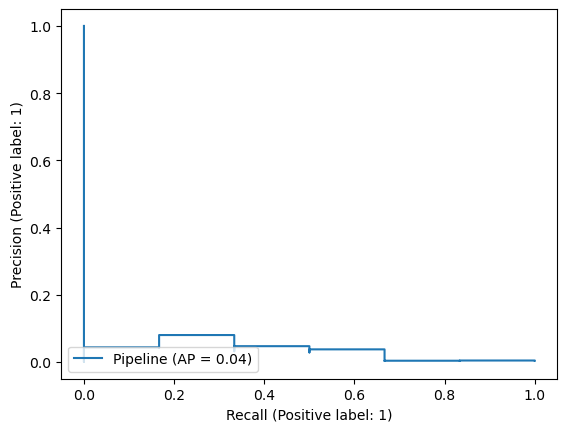

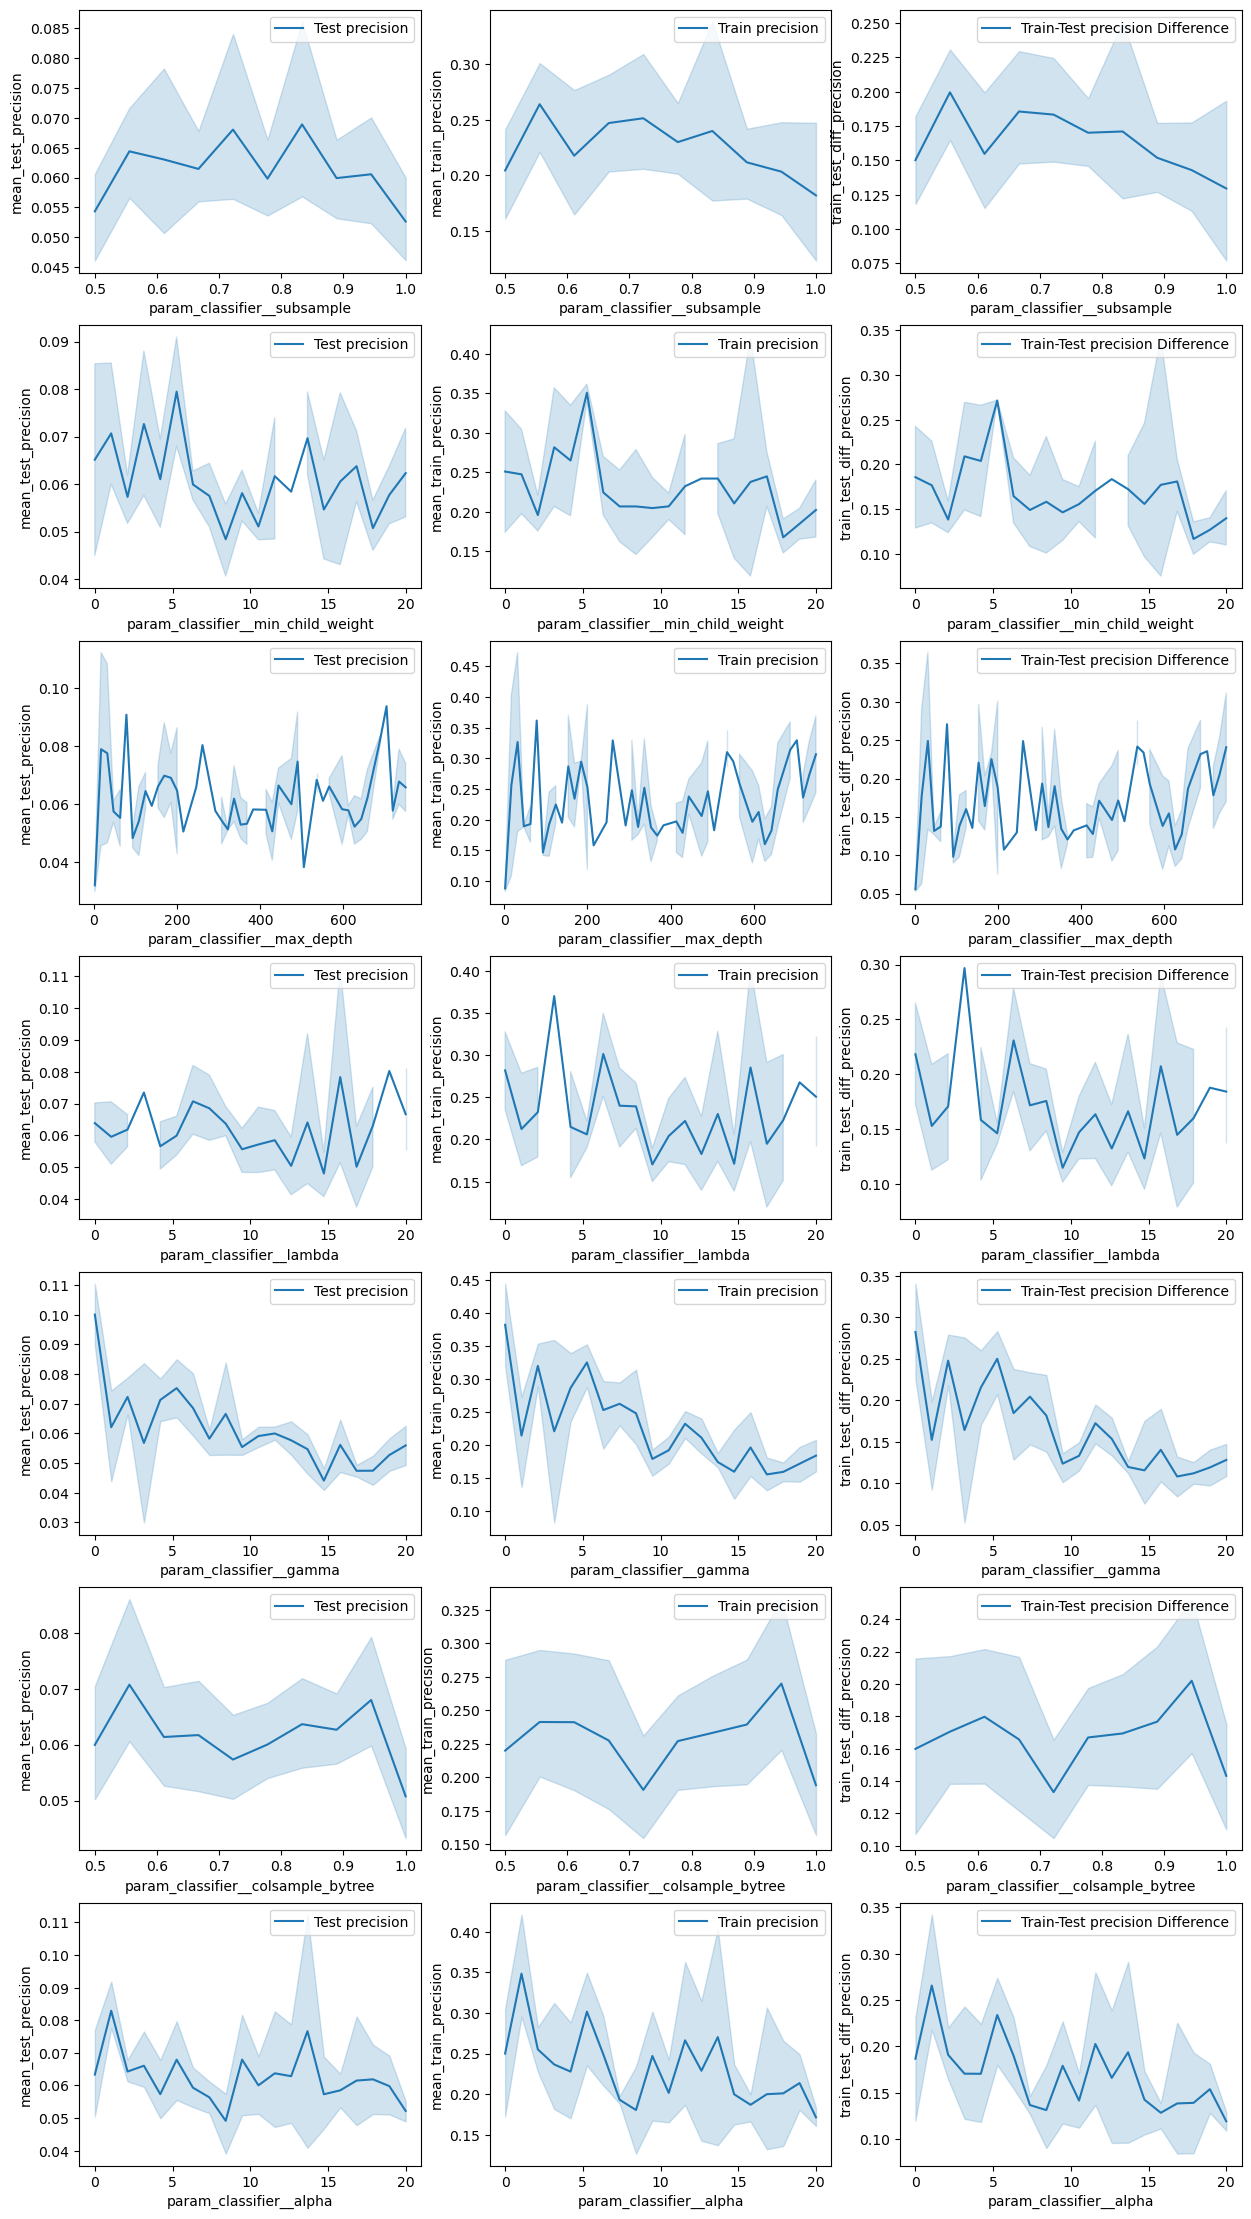

In [17]:
param_distributions = {
        #"classifier__eta": [i for i in np.linspace(0, 1, 20)]
        "classifier__gamma": [i for i in np.linspace(0, 20, 20)]
        ,"classifier__max_depth": [np.int64(i) for i in np.linspace(2, 750, 50)]
        ,"classifier__lambda": [i for i in np.linspace(0, 20, 20)]
        ,"classifier__alpha": [i for i in np.linspace(0, 20, 20)]
        ,"classifier__min_child_weight": [i for i in np.linspace(0, 20, 20)]
        ,"classifier__colsample_bytree": [i for i in np.linspace(0.5, 1, 10)]
        ,"classifier__subsample": [i for i in np.linspace(0.5, 1, 10)]
    }
classifier = XGBClassifier(n_jobs=None, eval_metric='pre', scale_pos_weight=scale_pos_weight, eta=0.63)
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('classifier', classifier)
    ])
random_search = run_experiment(features, param_distributions, pipeline, 
                               n_iter=100, n_splits=4, 
                               classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)

b. SMOTE

In [18]:
randsearch_params = {}
for param in list(random_search.best_params_.keys()):
    randsearch_params[param[12:]] = random_search.best_params_[param]

0.0


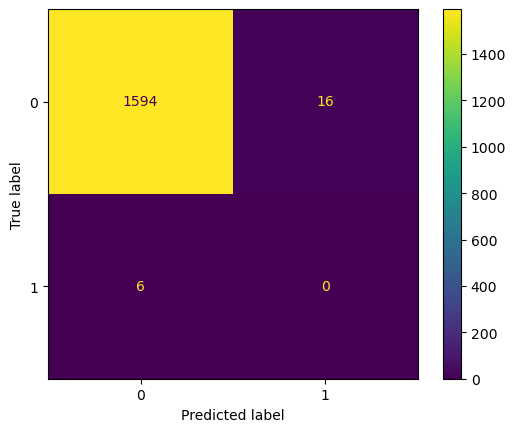

In [19]:
classifier = XGBClassifier(n_jobs=None, eval_metric='pre', eta=0.63, **randsearch_params)
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('over', SMOTE(sampling_strategy='not majority')),        
        ('classifier', classifier)
    ])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
print(precision_score(y_test, y_pred))

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV 1/4; 1/100] START classifier__alpha=13.68421052631579, classifier__colsample_bytree=0.6666666666666666, classifier__gamma=14.736842105263158, classifier__lambda=9.473684210526315, classifier__max_depth=429, classifier__min_child_weight=11.578947368421051, classifier__subsample=0.9444444444444444
[CV 1/4; 1/100] END classifier__alpha=13.68421052631579, classifier__colsample_bytree=0.6666666666666666, classifier__gamma=14.736842105263158, classifier__lambda=9.473684210526315, classifier__max_depth=429, classifier__min_child_weight=11.578947368421051, classifier__subsample=0.9444444444444444; precision: (train=0.197, test=0.067) total time=   0.5s
[CV 2/4; 1/100] START classifier__alpha=13.68421052631579, classifier__colsample_bytree=0.6666666666666666, classifier__gamma=14.736842105263158, classifier__lambda=9.473684210526315, classifier__max_depth=429, classifier__min_child_weight=11.578947368421051, classifier__subsampl

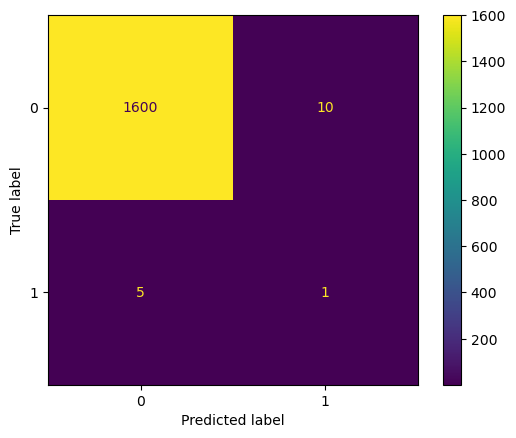

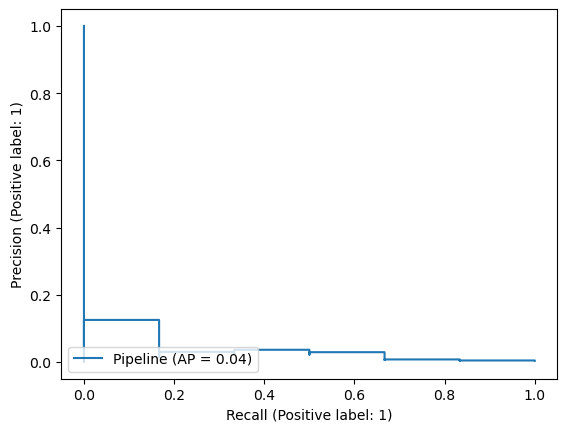

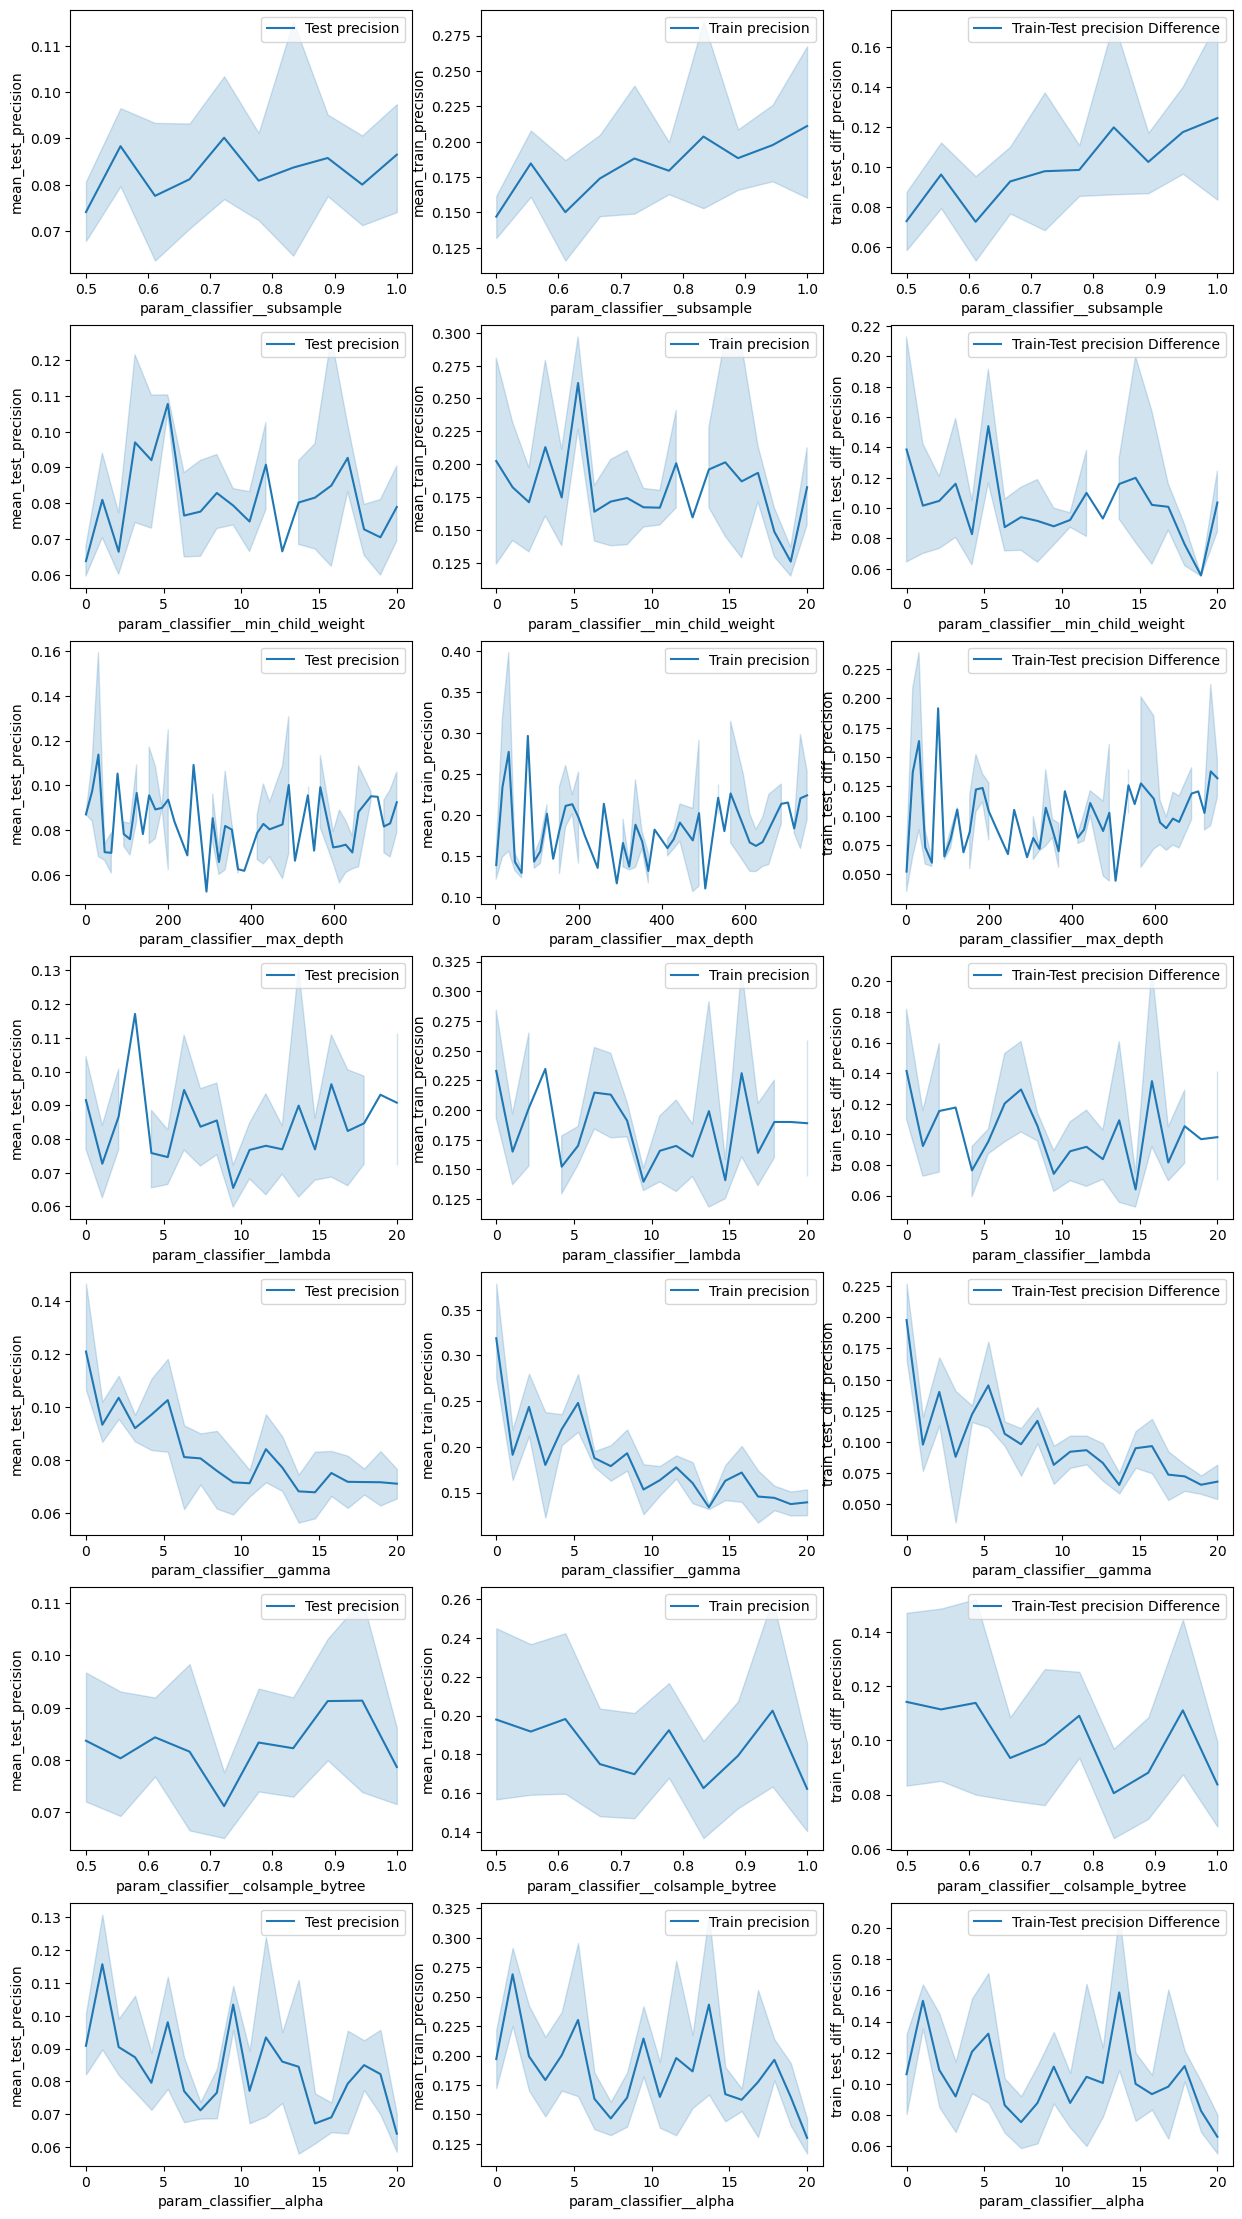

In [21]:
param_distributions = {
        #"classifier__eta": [i for i in np.linspace(0, 1, 20)]
        "classifier__gamma": [i for i in np.linspace(0, 20, 20)]
        ,"classifier__max_depth": [np.int64(i) for i in np.linspace(2, 750, 50)]
        ,"classifier__lambda": [i for i in np.linspace(0, 20, 20)]
        ,"classifier__alpha": [i for i in np.linspace(0, 20, 20)]
        ,"classifier__min_child_weight": [i for i in np.linspace(0, 20, 20)]
        ,"classifier__colsample_bytree": [i for i in np.linspace(0.5, 1, 10)]
        ,"classifier__subsample": [i for i in np.linspace(0.5, 1, 10)]
    }
classifier = XGBClassifier(n_jobs=None, eval_metric='pre', eta=0.89)
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor(one_hot_encoded_cols)),
        ('over', SMOTE(sampling_strategy='not majority')),
        ('classifier', classifier)
    ])
random_search = run_experiment(features, param_distributions, pipeline, 
                               n_iter=100, n_splits=4, 
                               classifier=classifier, one_hot_encoded_cols=one_hot_encoded_cols)